In [50]:
import pymongo
import numpy as np

db = pymongo.MongoClient()['mec']
dataset = 'calzedoniajson_items_0'

df, tf = {}, {}
docs = {}
cursor = db[dataset].find(no_cursor_timeout=True).sort('_id', pymongo.ASCENDING)
size = cursor.count()
for i, doc in enumerate(cursor):
    docs[i] = {'d': doc['_id'], 'tags': []}
    try:
        tags = doc['clarifai_tags']
        probs = doc['clarifai_probs']
        docs[i]['tags'] = tags
        for j, tag in enumerate(tags):
            try:
                posting = tf[tag]
            except KeyError:
                posting = {}
            posting[i] = {'raw_tf': 1, 'prob': probs[j], 
                            'norm_p': probs[j] / max(probs),
                           'freq': 1.0 / len(tags)}
            tf[tag] = posting
            try:
                df[tag]['df'] += 1
            except KeyError:
                df[tag] = {'df': 1.0}
            df[tag]['idf'] = np.log(1 + float(size) / df[tag]['df'])  
    except KeyError:
        pass
cursor.close()


In [54]:
def get_tf(tag, doc, metric='norm_p'):
    try:
        w = tf[tag][doc][metric]
    except KeyError:
        w = 0.0
    return w

def get_idf(tag, metric='idf'):
    try:
        w = df[tag][metric]
    except KeyError:
        w = 0.0
    return w

def bag(doc, tfm='norm_p', idfm='idf'):
    try:
        tgs = docs[doc]['tags']
        b = np.array([get_tf(x, doc, metric=tfm) * get_idf(x, metric=idfm)
                     for x in tgs])
    except KeyError:
        tgs = []
        b = np.array([])
    return tgs, b

def get_posting(tag, tfm='norm_p', idfm='idf'):
    p = []
    idf = get_idf(tag, metric=idfm)
    try:
        pd = tf[tag]
        for d, m in pd.items():
            p.append((d, m[tfm]*idf))
    except KeyError:
        pass
    return sorted(p, key=lambda x: -x[0])

print get_posting('girl')
    

[(447, 1.093395975003207), (445, 1.076287180670088), (443, 0.96819779380711202), (441, 1.0814423955806418), (438, 1.0532677513104634), (436, 1.0976956217364604), (435, 0.98130190388730698), (433, 1.0796087213440055), (432, 1.0872638126841967), (431, 1.0794887198286245), (429, 1.0616991347458082), (421, 1.0349844310923579), (420, 1.0263175654007952), (416, 1.0861250212985278), (415, 1.0644405144017905), (413, 1.0325474037321365), (406, 1.0090317855349991), (405, 0.95075651803343086), (400, 0.9641342574174433), (399, 1.104573558184609), (396, 1.1004531442369905), (390, 0.97261850657373006), (385, 1.0676145874719951), (383, 1.0696528302565638), (380, 0.9650612146302735), (377, 1.0299419756843702), (376, 1.104573558184609), (374, 1.0945870769187076), (373, 1.0853344170377561), (372, 1.0549941085742314), (368, 1.0331186868389319), (367, 1.066438323062755), (365, 0.99752456499500897), (364, 1.0701179305121946), (361, 1.011787798820273), (359, 1.0298056387227896), (356, 1.0783623486129563), (

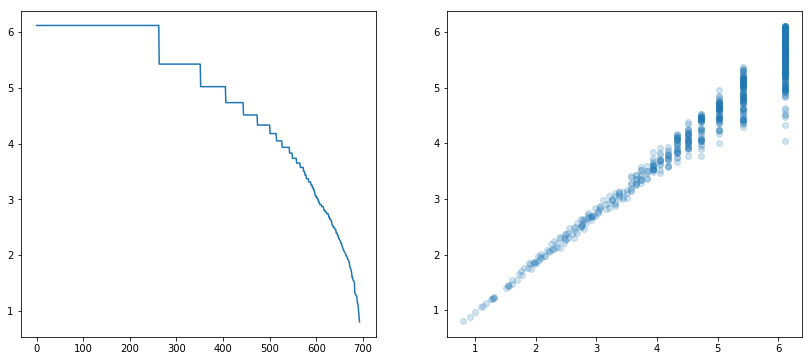

In [47]:
tag_list = tf.keys()
tag_len, tag_avg_w, tag_idf = [], [], []
for t in tag_list:
    p = get_posting(t)
    tag_len.append(len(p))
    tag_avg_w.append(np.mean([x[1] for x in p]))
    tag_idf.append(get_idf(t))

idf_y, w_y, l_y = [], [], []
for i, x in sorted(enumerate(tag_idf), key=lambda x: -x[1]):
    idf_y.append(x)
    w_y.append(tag_avg_w[i])
    l_y.append(max(tag_len[i:]))

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axes[0].plot(idf_y)
axes[1].scatter(idf_y, w_y, alpha=0.2)
plt.show()
